In [62]:
import boto3
import json
import decimal
from boto3.dynamodb.conditions import Key, Attr
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
from datetime import datetime

# Helper class to convert a DynamoDB item to JSON.
class DecimalEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, decimal.Decimal):
            if o % 1 > 0:
                return float(o)
            else:
                return int(o)
        return super(DecimalEncoder, self).default(o)

In [79]:
dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('SensorData')
fe = Key('SensorId').eq('AWS Setup')

In [80]:
def fetch_data(table, filter): 
    data = {
            'Timestamps' : [],
            'SensorIds' : [],
            'Values' : []
        }
    response = table.scan(
        FilterExpression=filter,
        )
    
    for i in response['Items']:
        data['Timestamps'].append(datetime.strptime(i['Timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ'))
        data['SensorIds'].append(i['SensorId'])
        data['Values'].append(float(i['Value']))

    while 'LastEvaluatedKey' in response:
        response = table.scan(
            FilterExpression=filter,
            ExclusiveStartKey=response['LastEvaluatedKey']
            )

        for i in response['Items']:
            data['Timestamps'].append(datetime.strptime(i['Timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ'))
            data['SensorIds'].append(i['SensorId'])
            data['Values'].append(float(i['Value']))
            
    return data

data = fetch_data(table, fe)

In [81]:
def segment_data(data, threshold): 
    if len(data['Timestamps']) == 0:
        return []
    segmented_data = []
    
    last_split = 0
    for i in range(1, len(data['Timestamps'])):
        diff = data['Timestamps'][i] - data['Timestamps'][i-1]
        if diff.seconds >= threshold:
            segmented_data.append({
                'Timestamps' : data['Timestamps'][last_split:i],
                'SensorIds' : data['SensorIds'][last_split:i],
                'Values' : data['Values'][last_split:i]
            })
            last_split = i

    segmented_data.append({
        'Timestamps' : data['Timestamps'][last_split:],
        'SensorIds' : data['SensorIds'][last_split:],
        'Values' : data['Values'][last_split:]
    })

    return segmented_data

segmented_data = segment_data(data, 5)

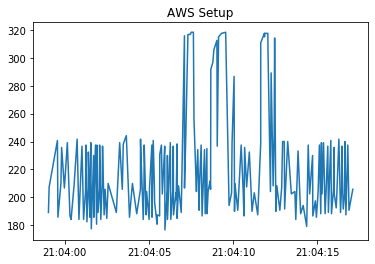

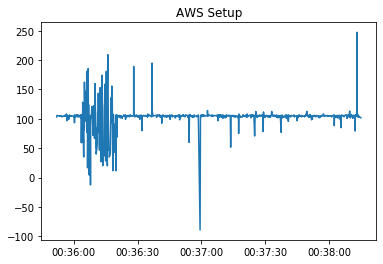

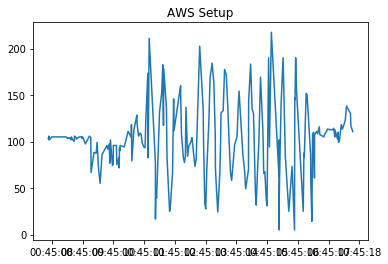

In [82]:
def display_data(data):
    plt.locator_params(axis='y', nbins=8)
    plt.plot_date(md.date2num(data['Timestamps']), data['Values'], '-')
    plt.title(data['SensorIds'][0])
    plt.show()
    
for data in segmented_data:
    display_data(data)